In [3]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131323 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [4]:
!ls

adc.json  sample_data


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
!ls

In [0]:
import os
os.chdir("drive/Colab Notebooks") 

In [7]:
!ls

 239_CNN_By_person.ipynb   ee239_new_lenet.ipynb
 239_CNN_sc_person.ipynb   EEG_loading.ipynb
 239_shallow.ipynb	   person_test.npy
 cnn_Vanilla.ipynb	   person_train_valid.npy
 cs260_FC.ipynb		   results
 cs260_hw3_CNN.ipynb	  'RNN_project_slidingW(1) (1).ipynb'
 cs260.ipynb		   X_test.npy
 ee239_500epoch.ipynb	   X_train_valid.npy
 ee239_basic_cnn.ipynb	   y_test.npy
 ee239.ipynb		   y_train_valid.npy


In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms


def flatten(x):
    """
    Input:
    - Tensor of shape (N, D1, ..., DM)
    Output:
    - Tensor of shape (N, D1 * ... * DM)
    """
    x_shape = x.size()
    new_shape = 1
    for i in range(len(x_shape) - 1):
        new_shape *= x_shape[i + 1]
    x_flat = x.reshape((x_shape[0],new_shape))
    return x_flat


############################################################################
#                                Architecture                              #
############################################################################
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1, 20), stride=(1, 10), padding=(2,10)),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.MaxPool2d(kernel_size=(13, 23), stride=(1, 6), padding=(1,6)),
            nn.BatchNorm2d(16),
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(16, 8, kernel_size=5, padding=0),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0),
            nn.BatchNorm2d(8),
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(8, 4, kernel_size=5, padding=0),
            nn.Softmax(dim=1),
        )

        """
        self.block3 = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
        )
        self.block4 = nn.Sequential(
            nn.Conv2d(16, 8, kernel_size=4, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(8),
        )
        self.block5 = nn.Sequential(
            nn.Conv2d(8, 4, kernel_size=1, padding=0),
            nn.Softmax(dim=1),
        )
        """

    def forward(self, x, viz=False):

        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        return flatten(x)



############################################################################
#                             Hyper parameters                             #
############################################################################
epochs = 40
batch_size = 64 


seed = 12345
device = 0
path = './results/model/'
log = './results/log/'

cuda = torch.cuda.is_available()

if cuda:
    torch.cuda.set_device(device)
    torch.cuda.manual_seed(seed)




X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")


X_train = X_train_valid.reshape((2115, 1, 25, 1000))
X_test = X_test.reshape((443, 1, 25, 1000))




trainset = torch.utils.data.TensorDataset(torch.from_numpy(X_train[:,:,:22,:]).float(), torch.from_numpy(y_train_valid - 769).long())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torch.utils.data.TensorDataset(torch.from_numpy(X_test[:,:,:22,:]).float(), torch.from_numpy(y_test - 769).long())
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

model = LeNet()
# if torch.cuda.is_available():
#     model = model.cuda()
if cuda:
    model = model.cuda()

############################################################################
#                                Optimization                              #
############################################################################
lr = 1e-3
#lr = 1e-3
#weight_decay=1e-3
#weight_decay = 1e-5
#betas=(0.9,0.99)
betas = (0.9, 0.999)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, betas=betas)

if not os.path.exists(path):
    os.makedirs(path)
if not os.path.exists(log):
    os.makedirs(log)

train_loss = []
train_acc = []
test_loss = []
test_acc = []
valid_loss=[]
valid_acc=[]


def save_model(state, path):
    torch.save(state, os.path.join(path))


def train(epoch):
    model.train()
    training_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (x, y) in enumerate(trainloader):
        if cuda:
            x = x.cuda()
            y = y.cuda()
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        training_loss += loss.item()
        _, predicted = output.max(1)
        total += y.size(0)
        correct += predicted.eq(y).sum().item()
    train_loss.append(training_loss/len(trainloader))
    train_acc.append(100.*correct/total)
    print('Training Epoch:{}, Training Loss:{:.6f}, Acc:{:6f}'.format(epoch, training_loss/len(trainloader), 100.*correct/total))

def test(epoch):
    model.eval()
    testing_loss = 0
    correct = 0
    total = 0

    for batch_idx, (x, y) in enumerate(testloader):
        if cuda:
            x = x.cuda()
            y = y.cuda()
        output = model(x)
        loss = criterion(output, y)
        
        testing_loss += loss.item()
        _, predicted = output.max(1)
        total += y.size(0)
        correct += predicted.eq(y).sum().item()
    test_loss.append(testing_loss/len(testloader))
    test_acc.append(100.*correct/total)
    print('Testing Epoch:{}, Testing Loss:{:.6f}, Acc:{:6f}.'.format(epoch, testing_loss/len(testloader), 100.*correct/total))

def valid(epoch):
    model.eval()
    validing_loss = 0
    correct = 0
    total = 0

    for batch_idx, (x, y) in enumerate(validloader):
        if cuda:
            x = x.cuda()
            y = y.cuda()
        output = model(x)
        loss = criterion(output, y)
        
        validing_loss += loss.item()
        _, predicted = output.max(1)
        total += y.size(0)
        correct += predicted.eq(y).sum().item()
    valid_loss.append(validing_loss/len(validloader))
    valid_acc.append(100.*correct/total)
    print('Validing Epoch:{}, Valid Loss:{:.6f}, Acc:{:6f}.'.format(epoch, validing_loss/len(validloader), 100.*correct/total))
    
    
def plot_loss(train_loss, test_loss):
    plt.plot(valid_loss, label = "valid")
    plt.plot(train_loss, label = "train")
    plt.xlabel("eopch")
    plt.ylabel("loss")
    plt.legend()
    plt.title("The loss against epoch")
    plt.show()


def plot_acc(train_acc, test_acc):
    plt.plot(valid_acc, label = "valid")
    plt.plot(train_acc, label = "train")
    plt.xlabel("eopch")
    plt.ylabel("accuracy")
    plt.legend()
    plt.title("The accuracy against epoch")
    plt.show()

  

In [9]:



x_test_list=[[] for i in range(9)]
y_test_list=[[] for i in range(9)]
for i in range(len(person_test)):
#   np.append(x_test_list[int(person_test[i][0])],X_test[i])
#   np.append(y_test_list[int(person_test[i][0])],y_test[i])
  x_test_list[int(person_test[i][0])].append(X_test[i])
  y_test_list[int(person_test[i][0])].append(y_test[i])
x_test_08=np.array(x_test_list)
y_test_08=np.array(y_test_list)
print(len(x_test_08[6]))
print(len(y_test_08[6]))
# print(x_test_08.shape)
print(X_train[:,:,:22,:].shape)

50
50
(2115, 1, 22, 1000)


In [0]:
def train(epoch):
    model.train()
    training_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (x, y) in enumerate(trainloader):
        if cuda:
            x = x.cuda()
            y = y.cuda()
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        training_loss += loss.item()
        _, predicted = output.max(1)
        total += y.size(0)
        correct += predicted.eq(y).sum().item()
    train_loss.append(training_loss/len(trainloader))
    train_acc.append(100.*correct/total)
    print('Training Epoch:{}, Training Loss:{:.6f}, Acc:{:6f}'.format(epoch, training_loss/len(trainloader), 100.*correct/total))

def test_people(subject):
    model.eval()
    testing_loss = 0
    correct = 0
    total = 0

    for batch_idx, (x, y) in enumerate(testloader):
        if cuda:
            x = x.cuda()
            y = y.cuda()
        output = model(x)
        loss = criterion(output, y)
        
        testing_loss += loss.item()
        _, predicted = output.max(1)
        total += y.size(0)
        correct += predicted.eq(y).sum().item()
    #test_loss.append(testing_loss/len(testloader))
    #test_acc.append(100.*correct/total)
    print('people:{}, Testing Loss:{:.6f}, Acc:{:6f}.'.format(subject+1, testing_loss/len(testloader), 100.*correct/total))


In [11]:
X_train_valid = X_train_valid.reshape((2115, 1, 25, 1000))
X_test = X_test.reshape((443, 1, 25, 1000))

index = np.arange(2115)
np.random.shuffle(index)
training_index, valid_index = index[:1715], index[1715:]
print(X_train_valid.shape)
X_train_valid = X_train_valid[:,:, :22, :]
X_train = X_train_valid[training_index]
X_valid = X_train_valid[valid_index]
X_test = X_test[:,:, :22, :]

y_train = y_train_valid[training_index]
y_valid = y_train_valid[valid_index]


trainset = torch.utils.data.TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train - 769).long())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

validset = torch.utils.data.TensorDataset(torch.from_numpy(X_valid).float(), torch.from_numpy(y_valid - 769).long())
validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=False, num_workers=2)

testset = torch.utils.data.TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test - 769).long())
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

(2115, 1, 25, 1000)


Training Epoch:0, Training Loss:1.379294, Acc:26.997085
Validing Epoch:0, Valid Loss:1.374021, Acc:33.000000.
Testing Epoch:0, Testing Loss:1.372841, Acc:34.311512.
Training Epoch:1, Training Loss:1.357513, Acc:33.702624
Validing Epoch:1, Valid Loss:1.373376, Acc:28.000000.
Testing Epoch:1, Testing Loss:1.370498, Acc:30.925508.
Training Epoch:2, Training Loss:1.341862, Acc:36.967930
Validing Epoch:2, Valid Loss:1.356507, Acc:35.750000.
Testing Epoch:2, Testing Loss:1.361913, Acc:33.860045.
Training Epoch:3, Training Loss:1.326957, Acc:39.650146
Validing Epoch:3, Valid Loss:1.358871, Acc:30.000000.
Testing Epoch:3, Testing Loss:1.355809, Acc:33.408578.
Training Epoch:4, Training Loss:1.311149, Acc:40.699708
Validing Epoch:4, Valid Loss:1.360461, Acc:29.250000.
Testing Epoch:4, Testing Loss:1.356809, Acc:31.828442.
Training Epoch:5, Training Loss:1.297230, Acc:43.556851
Validing Epoch:5, Valid Loss:1.358725, Acc:31.250000.
Testing Epoch:5, Testing Loss:1.355708, Acc:33.634312.
Training E

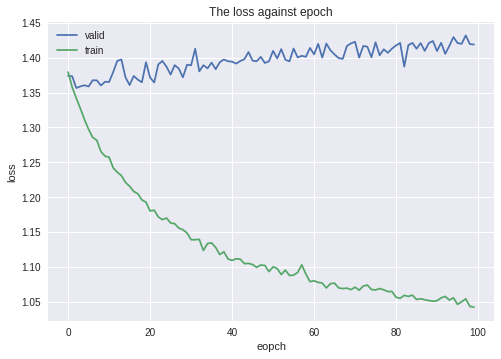

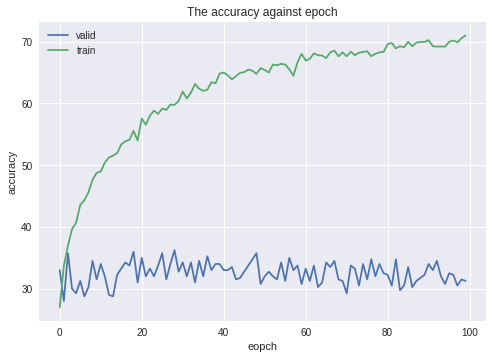

[34.31151241534989, 30.9255079006772, 33.86004514672686, 33.408577878103834, 31.82844243792325, 33.63431151241535, 33.182844243792324, 33.63431151241535, 33.408577878103834, 34.762979683972915, 33.86004514672686, 33.182844243792324, 30.02257336343115, 30.9255079006772, 32.957110609480814, 36.3431151241535, 30.9255079006772, 34.988713318284425, 36.3431151241535, 32.957110609480814, 35.44018058690745, 31.82844243792325, 32.27990970654628, 31.376975169300227, 31.82844243792325, 32.05417607223476, 33.63431151241535, 35.214446952595935, 33.182844243792324, 32.27990970654628, 32.957110609480814, 29.345372460496613, 34.31151241534989, 31.151241534988714, 31.151241534988714, 31.376975169300227, 32.957110609480814, 32.7313769751693, 32.50564334085779, 30.9255079006772, 34.31151241534989, 30.474040632054177, 31.151241534988714, 29.79683972911964, 32.05417607223476, 34.08577878103837, 32.05417607223476, 31.376975169300227, 32.05417607223476, 31.376975169300227, 31.151241534988714, 30.925507900677

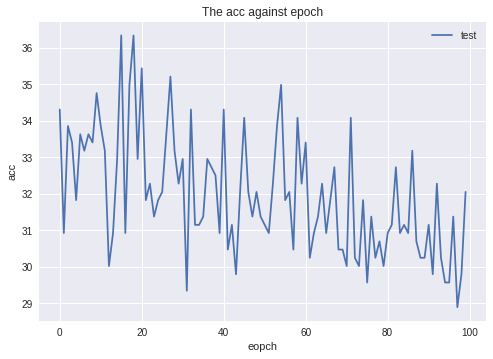

In [12]:

for i in range(100):
  train(i)
  valid(i)
  test(i)
  

#   if i%10==0:
#     print("#############################")
#     for i in range(9):
#       testset = torch.utils.data.TensorDataset(torch.from_numpy(np.array(x_test_08[i])[:,:,:22,:]).float(), torch.from_numpy(np.array(y_test_08[i]) - 769).long())
#       testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
#       test_people(i)
#     testset = torch.utils.data.TensorDataset(torch.from_numpy(X_test[:,:,:22,:]).float(), torch.from_numpy(y_test - 769).long())
#     testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
#     test_people(-1)
#    print("#############################")
plot_loss(train_loss, valid_loss)
plot_acc(train_acc, valid_acc)
print(test_acc)
plt.plot(test_acc, label = "test")
plt.xlabel("eopch")
plt.ylabel("acc")
plt.legend()
plt.title("The acc against epoch")
plt.show()

In [13]:
for i in range(9):
  testset = torch.utils.data.TensorDataset(torch.from_numpy(np.array(x_test_08[i])[:,:,:22,:]).float(), torch.from_numpy(np.array(y_test_08[i]) - 769).long())
  testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
  test_people(i)
testset = torch.utils.data.TensorDataset(torch.from_numpy(X_test[:,:,:22,:]).float(), torch.from_numpy(y_test - 769).long())
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
test_people(-1)

people:1, Testing Loss:1.416765, Acc:30.000000.
people:2, Testing Loss:1.343532, Acc:38.000000.
people:3, Testing Loss:1.413975, Acc:32.000000.
people:4, Testing Loss:1.349284, Acc:40.000000.
people:5, Testing Loss:1.413231, Acc:29.787234.
people:6, Testing Loss:1.365240, Acc:32.653061.
people:7, Testing Loss:1.457957, Acc:24.000000.
people:8, Testing Loss:1.442546, Acc:24.000000.
people:9, Testing Loss:1.319971, Acc:38.297872.
people:0, Testing Loss:1.391194, Acc:32.054176.


In [14]:
x_test_list_class=[[] for i in range(4)]
y_test_list_class=[[] for i in range(4)]
for i in range(len(y_test)):
  x_test_list_class[int(y_test[i])-769].append(X_test[i])
  y_test_list_class[int(y_test[i])-769].append(y_test[i])

x_test_class=np.array(x_test_list_class)
y_test_class=np.array(y_test_list_class)

train_acc = []
print(y_test_list_class)

[[769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769, 769], [770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 7

In [15]:
# trainset = torch.utils.data.TensorDataset(torch.from_numpy(X_train[:,:,:22,:]).float(), torch.from_numpy(y_train_valid - 769).long())
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

for i in range(4):
  testset = torch.utils.data.TensorDataset(torch.from_numpy(np.array(x_test_class[i])[:,:,:22,:]).float(), torch.from_numpy(np.array(y_test_class[i]) - 769).long())
  testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
  test_people(i)
testset = torch.utils.data.TensorDataset(torch.from_numpy(X_test[:,:,:22,:]).float(), torch.from_numpy(y_test - 769).long())
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
test_people(-1)


people:1, Testing Loss:1.503736, Acc:18.918919.
people:2, Testing Loss:1.297498, Acc:43.307087.
people:3, Testing Loss:1.468201, Acc:23.958333.
people:4, Testing Loss:1.328605, Acc:39.449541.
people:0, Testing Loss:1.391194, Acc:32.054176.
